# Predicting Yelp Star Ratings

In this little exercise, I am going to have a look at the distribution of Yelp ratings (1 to 5 stars) and their correlations to business and user attributes. Eventually I am testing several ML algorithms to predict a rating from business / user attributes and the review text.

### Import statements

In [1]:
import os, sys
import numpy as np
import scipy as sp
import pandas as pd
import random
import re

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')
matplotlib.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
%config InlineBackend.figure_formats=['svg']

In [2]:
def format_column_names(dataFrame):
    dataFrame.columns = dataFrame.columns.str.replace('[^\w.]+','_')
    dataFrame.columns = dataFrame.columns.str.lower()
    
pd.options.display.max_seq_items = 500

### User Settings

In [3]:
# The fraction (random sample) of the review dataset, which is to be parsed
# Table joining and text vectorization is demanding in terms of memory and cpu load,
# so I recommend a value <= 0.1.
REVIEW_FRAC = 0.05

### Verify the source directory

In [4]:
# Set the source directory for the input csv files (business.csv, user.csv, review.csv)
source_dir = os.path.join( os.getcwd(), 'scratch' )

required_files = ['business.csv', 'user.csv', 'review.csv']

nfiles_found = sum( os.path.isfile( os.path.join(source_dir, f) ) for f in required_files)
if nfiles_found < len(required_files):
    source_dir = input('Specify CSV source directory: ')
if nfiles_found < len(required_files):
    print('Source files not found.')
    sys.exit(1)
    
print('Source directory: {0}'.format(source_dir))

Source directory: /home/marco/workspace-python/YelpExercise/scratch


## Data Wrangling


### Load and format business data

In [5]:
businesses_file = os.path.join(source_dir, 'business.csv')

# Load business data
businesses = pd.read_csv( businesses_file,
    parse_dates=True,
    low_memory=False,
    index_col='business_id'
)
format_column_names(businesses)

In [6]:
# Drop irrelevant columns
irrel_cols = [col for col in list(businesses) if col.startswith('attributes.hair_types')]
businesses.drop(irrel_cols, axis=1, inplace=True)

# Identify column starting with 'attribute'
attr_cols = [col for col in list(businesses) if col.startswith('attributes.')]

# Convert attribute columns to numeric values (no/undefined/yes -> 0.0/0.5/1.0)
businesses[attr_cols] = businesses[attr_cols].replace(
    to_replace=[True, 'yes', 'full_bar', 'free', 'yes_free', 'quiet', 'yes_corkage', 'beer_and_wine'], value=1.0 )
businesses[attr_cols] = businesses[attr_cols].replace(
    to_replace=[False, 'no', 'none', 'very_loud'], value=0.0 )

businesses[attr_cols] = businesses[attr_cols].apply(pd.to_numeric, errors='coerce')
businesses[attr_cols] = businesses[attr_cols].fillna(value=0.5)

# Convert categorical data
#businesses['city'] = pd.Categorical(businesses['city']).codes
businesses['city'] = pd.factorize(businesses['city'])[0]

#businesses.columns
businesses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85901 entries, 5UmKMjUEUNdYWqANhGckJw to DH2Ujt_hwcMBIz8VvCb0Lg
Data columns (total 81 columns):
attributes.accepts_credit_cards      85901 non-null float64
attributes.accepts_insurance         85901 non-null float64
attributes.alcohol                   85901 non-null float64
attributes.ambience.casual           85901 non-null float64
attributes.ambience.classy           85901 non-null float64
attributes.ambience.divey            85901 non-null float64
attributes.ambience.hipster          85901 non-null float64
attributes.ambience.intimate         85901 non-null float64
attributes.ambience.romantic         85901 non-null float64
attributes.ambience.touristy         85901 non-null float64
attributes.ambience.trendy           85901 non-null float64
attributes.ambience.upscale          85901 non-null float64
attributes.attire                    85901 non-null float64
attributes.byob                      85901 non-null float64
attributes.byob_co

In [7]:
# Plot the business mean ratings
#star_counts = businesses.stars.value_counts(sort=False, normalize=True).sort_index()
#star_counts.plot(kind="bar", title="Business Mean Ratings", rot='0').set_xlabel('Rating')

### Load and format user data

In [8]:
users_file = os.path.join(source_dir, 'user.csv')

# Load user data
users = pd.read_csv( users_file, parse_dates=True, index_col='user_id' )
format_column_names(users)

compl_cols = [col for col in list(users) if col.startswith('compliments.')]
users['compliments'] = users[compl_cols].sum(axis=1)

vote_cols = [col for col in list(users) if col.startswith('votes.')]
users['votes'] = users[vote_cols].sum(axis=1)

#users.columns
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 686556 entries, 18kPq7GPye-YQ3LyKyAZPw to DL0S4Ro4KY77akGPbEkrug
Data columns (total 24 columns):
average_stars          686556 non-null float64
compliments.cool       101007 non-null float64
compliments.cute       25210 non-null float64
compliments.funny      71313 non-null float64
compliments.hot        74965 non-null float64
compliments.list       12584 non-null float64
compliments.more       57751 non-null float64
compliments.note       102211 non-null float64
compliments.photos     42338 non-null float64
compliments.plain      126161 non-null float64
compliments.profile    23716 non-null float64
compliments.writer     79860 non-null float64
elite                  686556 non-null object
fans                   686556 non-null int64
friends                686556 non-null object
name                   686555 non-null object
review_count           686556 non-null int64
type                   686556 non-null object
votes.cool             6865

### Load and format reviews data

In [9]:
reviews_file = os.path.join(source_dir, 'review.csv')

# count lines
#num_lines = sum(1 for _ in open(reviews_file))
num_lines = 10000000
# configure random line indices to skip
random.seed(123)
skip_idx = random.sample(range(1, num_lines), num_lines - int(REVIEW_FRAC*num_lines))

# only load a random fraction of the reviews dataset, specified by REVIEW_FRAC
reviews = pd.read_csv( reviews_file,
    parse_dates=True,
    index_col='review_id',
    skiprows=skip_idx
)
format_column_names(reviews)

reviews['text_length'] = reviews['text'].str.len()
reviews['text_wc'] = reviews['text'].str.split().apply(len)

vote_cols = [col for col in list(reviews) if col.startswith('votes.')]
reviews['votes'] = reviews[vote_cols].sum(axis=1)

times = pd.DatetimeIndex(reviews.date)
reviews['year'] = times.year

#reviews.columns
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134083 entries, Ya85v4eqdd6k9Od8HbQjyA to HyTJ9bUMWGIOP-xd1aQK9g
Data columns (total 13 columns):
business_id     134083 non-null object
date            134083 non-null object
stars           134083 non-null int64
text            134083 non-null object
type            134083 non-null object
user_id         134083 non-null object
votes.cool      134083 non-null int64
votes.funny     134083 non-null int64
votes.useful    134083 non-null int64
text_length     134083 non-null int64
text_wc         134083 non-null int64
votes           134083 non-null int64
year            134083 non-null int32
dtypes: int32(1), int64(7), object(5)
memory usage: 13.8+ MB


### Merge reviews, users and business tables (left joins)

In [10]:
%time rb = pd.merge(reviews, businesses, how='left', left_on='business_id', right_index=True, suffixes=('@reviews', '@businesses'))
%time rbu = pd.merge(rb, users, how='left', left_on='user_id', right_index=True, suffixes=('@reviews', '@users'))

#rbu['stars@reviews'].loc[rbu['votes@reviews'] >= 1].size

del businesses
del users
del reviews

#rbu.columns
rbu.info()

CPU times: user 132 ms, sys: 8 ms, total: 140 ms
Wall time: 143 ms
CPU times: user 436 ms, sys: 16 ms, total: 452 ms
Wall time: 453 ms
<class 'pandas.core.frame.DataFrame'>
Index: 134083 entries, Ya85v4eqdd6k9Od8HbQjyA to HyTJ9bUMWGIOP-xd1aQK9g
Columns: 118 entries, business_id to votes@users
dtypes: bool(1), float64(71), int32(1), int64(15), object(30)
memory usage: 120.3+ MB


# Exploratory Data Analysis

### Plot number of votes per review

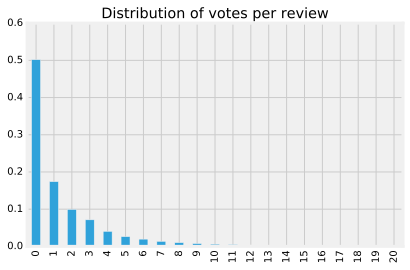

In [11]:
rbu['votes@reviews'].value_counts(normalize=True).ix[:20] \
    .plot.bar(rot=90, title='Distribution of votes per review')

### Investigate the distribution of ratings

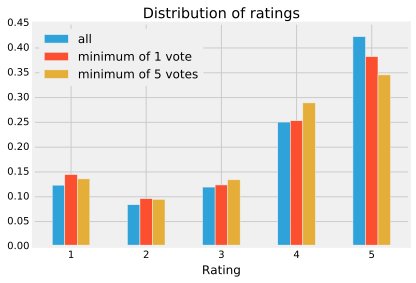

In [12]:
star_counts = rbu['stars@reviews'].value_counts(normalize=True).sort_index()
star_counts_min1 = rbu['stars@reviews'].loc[rbu['votes@reviews'] >= 1].value_counts(normalize=True).sort_index()
star_counts_min5 = rbu['stars@reviews'].loc[rbu['votes@reviews'] >= 5].value_counts(normalize=True).sort_index()

star_counts_comb = pd.concat([star_counts, star_counts_min1, star_counts_min5], axis=1)
star_counts_comb.columns = ['all', 'minimum of 1 vote', 'minimum of 5 votes']

star_counts_comb.plot.bar(title="Distribution of ratings", stacked=False, rot=0).set_xlabel('Rating')

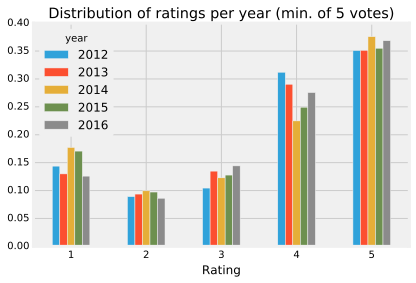

In [13]:
MIN_VOTES = 5
rbu_min_votes = rbu.loc[rbu['votes@reviews'] >= MIN_VOTES]

star_counts_per_year = rbu_min_votes.groupby(['year'])['stars@reviews'].value_counts(normalize=True).unstack().transpose()
star_counts_per_year[star_counts_per_year.columns[-5:]].plot.bar(title="Distribution of ratings per year (min. of {0} votes)".format(MIN_VOTES), stacked=False, rot=0).set_xlabel('Rating')

### Investigate correlations with the ratings column

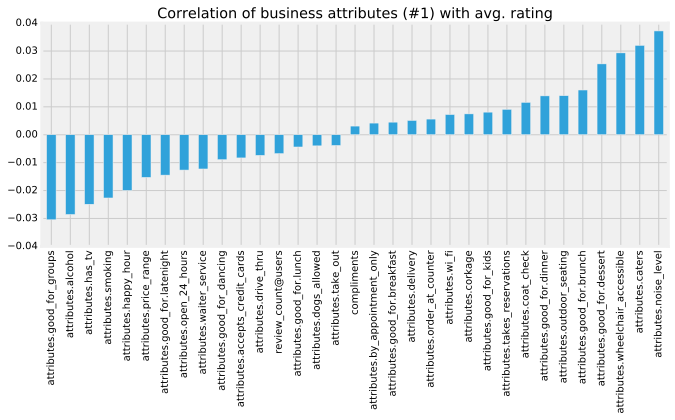

In [14]:
cols = ['attributes.accepts_credit_cards',
 'attributes.alcohol',
 'attributes.by_appointment_only',
 'attributes.caters',
 'attributes.coat_check',
 'attributes.corkage',
 'attributes.delivery',
 'attributes.dogs_allowed',
 'attributes.drive_thru'] \
  + [col for col in list(rbu) if col.startswith('attributes.good_for')] \
  + ['attributes.happy_hour',
 'attributes.has_tv',
 'attributes.noise_level',
 'attributes.open_24_hours',
 'attributes.order_at_counter',
 'attributes.outdoor_seating',
 'attributes.price_range',
 'attributes.smoking',
 'attributes.take_out',
 'attributes.takes_reservations',
 'attributes.waiter_service',
 'attributes.wheelchair_accessible',
 'attributes.wi_fi',
 'review_count@users',
 'compliments']
correls = rbu[cols].corrwith(rbu['stars@reviews'], drop=True).sort_values()
correls.plot.bar(figsize=(10,4), title='Correlation of business attributes (#1) with avg. rating')

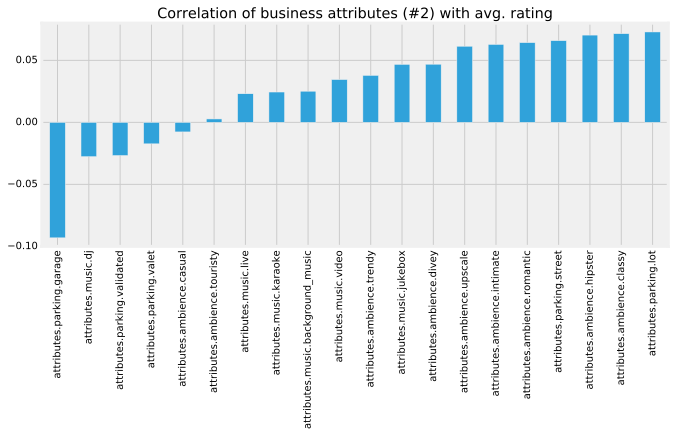

In [15]:
cols = [col for col in list(rbu) if re.search('(\.ambience|\.music|\.parking)', col)]
correls = rbu[cols].corrwith(rbu['stars@businesses'], drop=True).sort_values()
correls.plot.bar(figsize=(10,4), title='Correlation of business attributes (#2) with avg. rating')

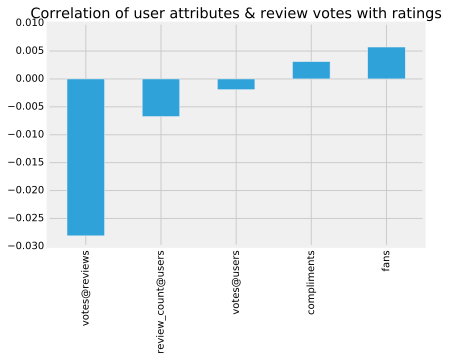

In [16]:
cols = ['compliments', 'votes@reviews', 'votes@users', 'review_count@users', 'fans']
correls = rbu[cols].corrwith(rbu['stars@reviews'], drop=True).sort_values()
correls.plot.bar(title='Correlation of user attributes & review votes with ratings')

In [17]:
# rbu.loc[rbu['votes'] >= 5].groupby(['stars_review'])['text_length'].mean().plot.bar(title="Mean review length (characters) vs. rating (min. of 5 votes)", stacked=False, rot=0).set_xlabel('Rating')

### Investigate the relation between review word count and rating

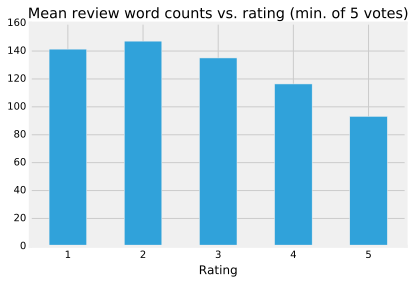

In [18]:
rbu.groupby(['stars@reviews'])['text_wc'].mean().plot.bar(title="Mean review word counts vs. rating (min. of 5 votes)", stacked=False, rot=0).set_xlabel('Rating')

# Predictive Data Analysis
## Predict a rating from business/user attributes and the review text

### Split the available data into training and test set

In [19]:
data_train, data_test = train_test_split(
    rbu,
    test_size = 0.2,
    random_state=1
)

# column containting the review texts
text_col = 'text'

# column containing the label
label_col = 'stars@reviews'

# columns containting attribute features
attr_cols = [col for col in list(rbu) if re.match('(votes\..+@users|votes\..+@reviews|attributes\.|city)', col)]
#attr_cols

### Vectorize the review texts

In [20]:
# train the vectorizer from training data (review texts)
vect = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    strip_accents='unicode',
    max_df=0.9,
    min_df=3,
    max_features=100000
)
vect.fit(data_train[text_col])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=100000, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### Prepare features and labels

In [21]:
# collect features
#X_train_attr = data_train[attr_cols]
#X_test_attr = data_test[attr_cols]
X_train_attr = pd.get_dummies( data_train[attr_cols] )
X_test_attr = pd.get_dummies( data_test[attr_cols] )

X_train_dtm = vect.transform(data_train[text_col])
X_test_dtm = vect.transform(data_test[text_col])

# collect labels
y_train = data_train[label_col]
y_test = data_test[label_col]

In [22]:
# combine attribute matrices and sparse document-term matrices
X_train = sp.sparse.hstack((X_train_dtm, X_train_attr))
X_test = sp.sparse.hstack((X_test_dtm, X_test_attr))

### Multinomial Naive Bayes (using review texts only)

In [23]:
# use a Multinomial Naive Bayes model
nb = MultinomialNB(
    alpha=0.1
)
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [24]:
# make class predictions for X_test_dtm
y_pred = nb.predict(X_test_dtm)

In [25]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

0.59089383599955247

In [26]:
# calculate the mean error (more meaningful in our case)
metrics.mean_absolute_error(y_test, y_pred)

0.5408509527538502

In [27]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[2264,  687,  182,   80,   70],
       [ 549,  718,  643,  256,  103],
       [ 274,  378, 1174, 1094,  255],
       [ 221,  158,  765, 3763, 1857],
       [ 360,   64,  182, 2793, 7927]])

In [28]:
# examine how often tokens of our dictionary appear in each rating category
tokens = pd.DataFrame(
    {'token': vect.get_feature_names(),
     '1 star'  : nb.feature_count_[0, :] / nb.class_count_[0],
     '2 stars' : nb.feature_count_[1, :] / nb.class_count_[1],
     '3 stars' : nb.feature_count_[2, :] / nb.class_count_[2] ,
     '4 stars' : nb.feature_count_[3, :] / nb.class_count_[3] ,
     '5 stars' : nb.feature_count_[4, :] / nb.class_count_[4]}
).set_index('token')
tokens.sample(10, random_state=3)

,1 star,2 stars,3 stars,4 stars,5 stars
token,,,,,
simple breakfast,0.000151,0.000223,0.000389,0.000149,0.000066
meal experience,0.000151,0.000334,0.000156,0.000485,0.000331
brazilians,0.000075,0.000000,0.000233,0.000075,0.000154
bar beautiful,0.000000,0.000334,0.000233,0.000075,0.000044
development,0.000604,0.000334,0.000545,0.000857,0.000485
sure day,0.000075,0.000000,0.000156,0.000037,0.000110
chili verde,0.000000,0.000334,0.000233,0.000298,0.000176
place deserves,0.000679,0.000445,0.000467,0.000298,0.000661
wine time,0.000151,0.000000,0.000389,0.000112,0.000044


### Multinomial Naive Bayes (using business / user attributes only)

In [29]:
# use a Multinomial Naive Bayes model
nb = MultinomialNB(
    alpha=0.1
)
nb.fit(X_train_attr, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [30]:
# make class predictions for X_test_dtm
y_pred = nb.predict(X_test_attr)

In [31]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

0.16810232315322371

In [32]:
# calculate the mean error (more meaningful in our case)
metrics.mean_absolute_error(y_test, y_pred)

2.4143267330424729

In [33]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[3013,   51,  102,   36,   81],
       [1754,  112,  220,   61,  122],
       [1964,  261,  533,  177,  240],
       [4406,  495,  988,  364,  511],
       [9631,  360,  590,  259,  486]])

### Multinomial Naive Bayes (using review texts and additional attributes)

In [34]:
# use a Multinomial Naive Bayes model
nb = MultinomialNB(
    alpha=0.1
)
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [35]:
# make class predictions for X_test_dtm
y_pred = nb.predict(X_test)

In [36]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

0.22150128649737108

In [37]:
# calculate the mean error (more meaningful in our case)
metrics.mean_absolute_error(y_test, y_pred)

2.1764925233993364

In [38]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[3027,   93,  109,   19,   35],
       [1738,  186,  230,   35,   80],
       [1860,  275,  524,  216,  300],
       [3850,  230,  833,  647, 1204],
       [8783,   76,  452,  459, 1556]])

### Stochastic Gradient Descent  (using review texts only)

In [39]:
# use a linear model with stochastic gradient descent (SGD)
sgd = SGDClassifier(
    loss='modified_huber',
    penalty='l2',
    alpha=1e-3,
    n_iter=20,
    n_jobs=1,
    random_state=0)
sgd.fit(X_train_dtm, y_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=20, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False)

In [40]:
# make class predictions for X_test_dtm
y_pred = sgd.predict(X_test_dtm)

In [41]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

0.62005444307715252

In [42]:
# calculate the mean error (more meaningful in our case)
metrics.mean_absolute_error(y_test, y_pred)

0.50986314651154119

In [43]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[2490,  299,  103,  103,  288],
       [ 715,  553,  439,  296,  266],
       [ 223,  324,  951, 1035,  642],
       [  83,  124,  502, 2667, 3388],
       [  51,   38,   99, 1171, 9967]])

### Decision Tree

In [44]:
dtree = DecisionTreeClassifier(
    criterion='entropy',
    random_state=0,
    min_samples_leaf=10,
    max_depth=None
)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [45]:
# make class predictions for X_test_dtm
y_pred = dtree.predict(X_test)

In [46]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

0.48152291456911661

In [47]:
# calculate the mean error
metrics.mean_absolute_error(y_test, y_pred)

0.84133199090129396

In [48]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[1750,  408,  217,  295,  613],
       [ 576,  370,  334,  485,  504],
       [ 293,  375,  722, 1012,  773],
       [ 302,  359,  863, 2536, 2704],
       [ 474,  262,  544, 2511, 7535]])

### Random Forest Classifier

In [49]:
rf = RandomForestClassifier(
    random_state=0,
    n_estimators=20,
    criterion='entropy',
    n_jobs=3,
    max_depth=150
)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=3, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [50]:
# make class predictions for X_test_dtm
y_pred = rf.predict(X_test)

In [51]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

0.5302979453331842

In [52]:
# calculate the mean error
metrics.mean_absolute_error(y_test, y_pred)

0.79658425625536045

In [53]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[1661,   98,   85,  256, 1183],
       [ 454,  138,  198,  524,  955],
       [ 200,   81,  277, 1211, 1406],
       [  94,   42,  200, 2170, 4258],
       [  83,   18,   65, 1185, 9975]])